# Regression analsysis for estimating causal effects: prepare data

In [4]:
from enstools.io import read
from enstools.plot import contour
import matplotlib.pyplot as plt
import matplotlib as mpl
import glob
import pandas as pd
import xarray as xr
import numpy as np
import dask
import seaborn as sns
import logging
from enstools.io import read
from sklearn.cluster import KMeans
from statsmodels.regression.linear_model import OLS
from sklearn import preprocessing
import graphviz as gv
from IPython.display import Image
from tqdm import tqdm
homedir = '/home/m/M.Hirt/'
outdir_data = homedir + 'Cold_Pools/Mistral_work/Data/cp_characteristics_fixed2019/'
plt.style.use(['seaborn-deep', '/home/m/M.Hirt/poster.mplstyle'])
%matplotlib inline
logger = logging.getLogger()
logger.setLevel(logging.INFO)
grid_ordered = ['625m', '312m', '156m']
mask_order = ['no_coldpool','cp_mask','cp_edges']


import warnings
warnings.filterwarnings("ignore")

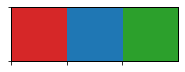

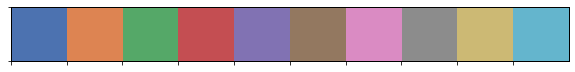

In [5]:
current_palette = sns.color_palette('tab10')
grid_colors =[ current_palette[i] for i in [3,0,2]]
secondary_colors= sns.color_palette('deep')#[sns.color_palette('deep')[i] for i in [3,9,8,2,1,0,4,6,7]]
sns.palplot(grid_colors)
sns.palplot(secondary_colors)

In [6]:
def load_data_tracks_selected(characteristics='cp_aggregates', dates = ['20140815','20150705', '20160529', '20160606', '20160801'],
              doms = ['DOM01', 'DOM02','DOM03'], rename_doms=True):
    ci_mask = 'ci_mask_clw_mlvi_60-110_2.0_*'
    cp_edges = 'cp_edges_20_and_gustfronts_filter_gradient_4_90.00_70'
    ds2=[]
    outdir_data = homedir + 'Cold_Pools/Mistral_home/Data/cp_characteristics_fixed2019/'
    for date in dates:
        ds0=[]
        for dom in doms:
            if characteristics=='prec':
                cp_aggregates_fname = '%s%s/%s/cold_pool_characteristics/%s/%s/prec_%s_%s.nc'%(outdir_data, date, dom, ci_mask , cp_edges, dom, date)
            else:
                cp_aggregates_fname =outdir_data + date + '/'+ dom+ '/tracked_cold_pool_characteristics/*/*/'+characteristics +'__height*' 
            logging.debug(cp_aggregates_fname)
            try:
                cp_aggregates_fname = glob.glob(cp_aggregates_fname)[0]
            except:
                logging.warning('cp_aggregates_fname is empty for %s, %s!'%(date, dom))
                continue
            print(cp_aggregates_fname)
            logging.debug(cp_aggregates_fname)
            #egg = read(cp_aggregates_fname).compute()
            egg = xr.open_dataset(cp_aggregates_fname)
            egg['dom']=dom
            egg = egg.set_coords('dom')
            if date=='20140815':
                egg = egg.resample(time='5min').interpolate('linear')
            if 'cp_tracks' in egg.mask.values:
                masks = list(egg.mask.values)
                masks[masks.index('cp_tracks')]='cp_mask'
                egg.mask.values = masks
            logging.debug(egg)
            egg = egg[['intensity','buoyancy_CPtop', 'n_triggering','n_gridpoints', 'TOT_PREC', #'hus', 'hdiv_ll', 'theta_v', 
                       'wa','massflux_u','massflux_d', 'time','cp_index','mask','pctl_stats',# 'pt_rho_pert', 
                      # 'theta_CPtop',  'hus_CPtop'
                      ]]
            egg = egg.sel(pctl_stats=['mean', 'sum', '5pctl','95pctl']).persist()
            ds_sel=xr.Dataset()
            ds_sel['intensity_mean_cp'] = egg['intensity'].sel(pctl_stats='mean', mask = 'cp_mask')
            ds_sel['intensity_sum_cp'] = egg['intensity'].sel(pctl_stats='sum', mask = 'cp_mask')
            
            #ds_sel['hus_CPtop_mean_cp'] = egg['hus_CPtop'].sel(pctl_stats='mean', mask = 'cp_mask')
            #ds_sel['theta_CPtop_mean_cp'] = egg['theta_CPtop'].sel(pctl_stats='mean', mask = 'cp_mask')
            ds_sel['buoyancy_CPtop_mean_cp'] = egg['buoyancy_CPtop'].sel(pctl_stats='mean', mask = 'cp_mask')
            ds_sel['n_gridpoints_cp'] = egg['n_gridpoints'].sel( mask = 'cp_mask')
            ds_sel['n_triggering_cp'] = egg['n_triggering'].sel( mask = 'cp_mask')
            ds_sel['TOT_PREC_mean_cp'] = egg['TOT_PREC'].sel(pctl_stats='mean', mask = 'cp_mask')
            ds_sel['TOT_PREC_sum_cp'] = egg['TOT_PREC'].sel(pctl_stats='sum', mask = 'cp_mask')
            ds_sel['massflux_d_mean_cp'] = egg['massflux_d'].sel(pctl_stats='mean', mask = 'cp_mask')
            ds_sel['massflux_d_sum_cp'] = egg['massflux_d'].sel(pctl_stats='sum', mask = 'cp_mask')
            ds_sel['wa_5_cp'] = egg['wa'].sel(pctl_stats='5pctl', mask = 'cp_mask')
            
            ds_sel['n_gridpoints_cpe'] = egg['n_gridpoints'].sel( mask = 'cp_edges')
            ds_sel['n_triggering_cpe'] = egg['n_triggering'].sel( mask = 'cp_edges')
            ds_sel['wa_95_cpe'] = egg['wa'].sel(pctl_stats='95pctl', mask = 'cp_edges')
            #ds_sel['hus_CPtop_95_cpe'] = egg['hus_CPtop'].sel(pctl_stats='95pctl', mask = 'cp_edges')
            #ds_sel['theta_CPtop_95_cpe'] = egg['theta_CPtop'].sel(pctl_stats='95pctl', mask = 'cp_edges')
            ds_sel['massflux_u_mean_cpe'] = egg['massflux_u'].sel(pctl_stats='mean', mask = 'cp_edges')
            ds_sel['massflux_u_sum_cpe'] = egg['massflux_u'].sel(pctl_stats='sum', mask = 'cp_edges')
            #ds_sel['hdiv_ll_5_cpe'] = egg['hdiv_ll'].sel(pctl_stats='5pctl', mask = 'cp_edges')
            ds_sel['buoyancy_CPtop_95_cpe'] = egg['buoyancy_CPtop'].sel(pctl_stats='95pctl', mask = 'cp_edges')
            
            
            # read in track initiation/determination file:
            if characteristics=='cp_aggregates2': 
                fname = glob.glob("/home/m/M.Hirt/Cold_Pools/Mistral_work_sophia/cold_pools/%s-*/irt_tracks_tab_%s*%s*.txt"%(date,date,dom))
                track_type = pd.read_csv(fname[0], header = None,delim_whitespace=True, escapechar='*')
                del track_type[0]; 
                track_type = track_type.rename(columns={1:'cp_index',2: 'starting_time_step',3: 'track_duration',4:'track_initiation_type',5:'track_determination_type'})#;
                track_type['cp_index'] = track_type.cp_index#-1
                track_type =track_type.set_index('cp_index');
                ds_sel['track_initiation_type'] =track_type.track_initiation_type.to_xarray()
                ds_sel['track_determination_type'] =track_type.track_determination_type.to_xarray()
                ds_sel['track_duration'] =track_type.track_duration.to_xarray() 
                if date =="20140815":
                    ds_sel['track_duration'] =track_type.track_duration.to_xarray()*15
                else:
                    ds_sel['track_duration'] =track_type.track_duration.to_xarray()*5

            if ds0!=[]:
                ds_sel['cp_index'] = ds_sel.cp_index + ds0[-1].cp_index.max()+1


            ds0.append(ds_sel.persist())
        ds=xr.concat(ds0, dim ='dom')
        if ds2!=[]:
            ds['cp_index'] = ds.cp_index + ds2[-1].cp_index.max()+1
        ds2.append(ds)
    ds=xr.concat(ds2,dim='time')
    ds['p_ci_cp']= ds.n_triggering_cp/ds.n_gridpoints_cp
    ds['p_ci_cpe']= ds.n_triggering_cpe/ds.n_gridpoints_cpe
    ds=ds.where(np.isnan(ds.intensity_mean_cp)==False)

    ds['date']=ds.time.copy()
    ds['date'].values = pd.to_datetime(ds.time.values).date.astype('str')
    ds['time_hhmm'] = ds.time.copy(deep=True)
    ds['time_hhmm'].values = pd.to_datetime(ds.time.values).time#.astype('str')
    if rename_doms: 
        ds['dom']= ['625m', '312m', '156m']
        ds=ds.rename(dict(dom='grid_size')).sortby('grid_size')
        
    return ds

## synoptic conditions data (domain mean) + other cold pool data 

In [7]:
# load synoptic variables 
outdir_data_sc = homedir + 'Cold_Pools/Mistral_home/Data/synoptic_conditions_variables.nc'
ds_sc = read(outdir_data_sc)
ds_sc['dom']= ['625m', '312m', '156m']
ds_sc=ds_sc.rename(dict(dom='grid_size')).sortby('grid_size')
del ds_sc['date']

In [8]:
logger.setLevel(logging.INFO)
ds = load_data_tracks_selected('cp_aggregates2_not_tracked_166_96', dates = ['20150705', '20160529', '20160606', '20160801'])

/home/m/M.Hirt/Cold_Pools/Mistral_home/Data/cp_characteristics_fixed2019/20150705/DOM01/tracked_cold_pool_characteristics/ci_mask_clw_mlvi_60-110_2.0_0.97/cp_edges_20_and_gustfronts_filter_gradient_4_90.00_70/cp_aggregates2_not_tracked_166_96__height131_DOM01_20150705.nc
/home/m/M.Hirt/Cold_Pools/Mistral_home/Data/cp_characteristics_fixed2019/20150705/DOM02/tracked_cold_pool_characteristics/ci_mask_clw_mlvi_60-110_2.0_0.97/cp_edges_20_and_gustfronts_filter_gradient_4_90.00_70/cp_aggregates2_not_tracked_166_96__height131_DOM02_20150705.nc
/home/m/M.Hirt/Cold_Pools/Mistral_home/Data/cp_characteristics_fixed2019/20150705/DOM03/tracked_cold_pool_characteristics/ci_mask_clw_mlvi_60-110_2.0_0.97/cp_edges_20_and_gustfronts_filter_gradient_4_90.00_70/cp_aggregates2_not_tracked_166_96__height131_DOM03_20150705.nc
/home/m/M.Hirt/Cold_Pools/Mistral_home/Data/cp_characteristics_fixed2019/20160529/DOM01/tracked_cold_pool_characteristics/ci_mask_clw_mlvi_60-110_2.0_0.93/cp_edges_20_and_gustfronts_fi

### merge synoptic data with other data 

In [9]:
for var in list(ds_sc.keys()):
    var_str = 'sc_'+ var
    ds[var_str] = ds_sc[var]

In [10]:
list(ds_sc.keys())

['cin_ml',
 'cape_ml',
 'windspeed_1km',
 'windspeed_sfc',
 'z_pbl',
 'thetav_1km',
 'thetav_sfc',
 'hus_sfc',
 'hus_1km',
 'N2',
 'wa_5km',
 'CAPE_shear',
 'BRN',
 'deep_shear']

In [11]:
ds_sc['date']=ds_sc.time.copy()
ds_sc['date'].values = pd.to_datetime(ds_sc.time.values).date.astype('str')
ds_sc['time_hhmm'] = ds_sc.time.copy(deep=True)
ds_sc['time_hhmm'].values = pd.to_datetime(ds_sc.time.values).time#.astype('str')
ds_sc['BRN_log'] = np.log(ds_sc.BRN)
df_sc = ds_sc.to_dataframe()
df_sc = df_sc.reset_index()
del df_sc['time']
df_sc = df_sc.dropna(how='any')

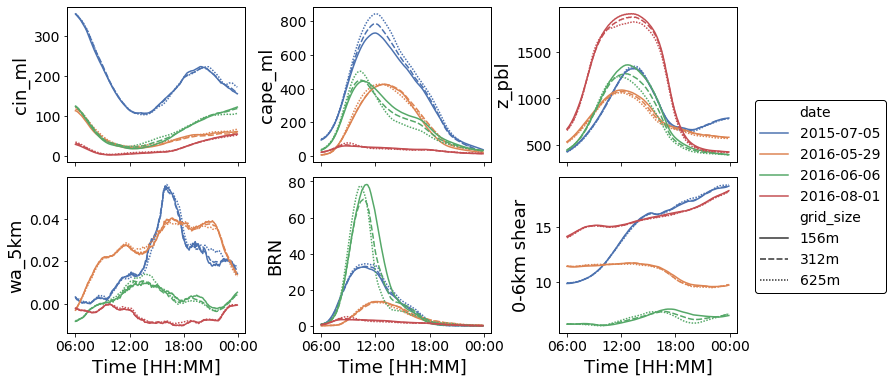

In [12]:
import matplotlib.dates as md
fig, axs= plt.subplots(nrows=2,ncols=3, figsize=[12,6], sharex=True)
axs=axs.ravel()
i = 0
for var in ['cin_ml', 'cape_ml','z_pbl', 'wa_5km', 'BRN', 'deep_shear']:
    sns.lineplot(data = df_sc, x = 'time_hhmm', hue='date', style='grid_size', y = var, ax = axs[i], palette = secondary_colors[:4])
    axs[i].get_legend().remove()
    ticks = np.arange(6,25,6)*3600
    axs[i].set_xticks( ticks)
    axs[i].set_xlabel('Time [HH:MM]')
    i+=1

axs[i-1].legend(bbox_to_anchor=(1.1, 1.5), loc=2, borderaxespad=0.)   
axs[i-1].set_ylabel('0-6km shear')
fig.subplots_adjust(hspace=.1, wspace=.38)

fig.savefig('../Figures/synoptic_conditions_plots.pdf')


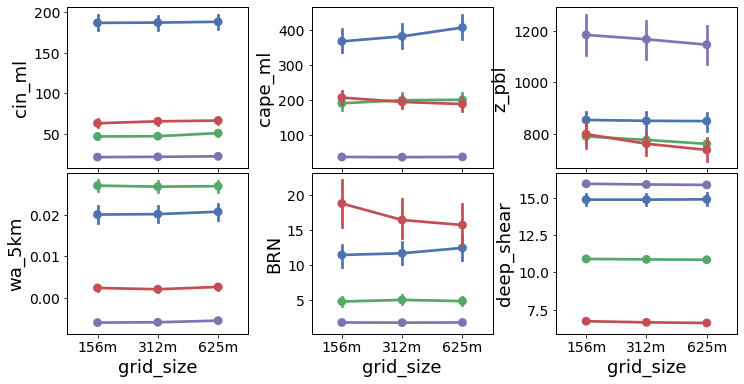

In [10]:
import matplotlib.dates as md
fig, axs= plt.subplots(nrows=2,ncols=3, figsize=[12,6], sharex=True)
axs=axs.ravel()
i = 0
for var in ['cin_ml', 'cape_ml','z_pbl', 'wa_5km', 'BRN', 'deep_shear']:
    sns.pointplot(data = df_sc, x = 'grid_size',y = var, ax = axs[i], hue ='date')
    axs[i].get_legend().remove()
    i+=1

#axs[i-1]legend(bbox_to_anchor=(1.1, 1.5), loc=2, borderaxespad=0.)   
fig.subplots_adjust(hspace=0.03, wspace=.35)

fig.savefig('../Figures/synoptic_conditions_plots_resolution_differenc.pdf')


## prepare data: to pandas dataframe, normalize, ...

In [13]:
ds['cp_radius'] = np.sqrt(ds['n_gridpoints_cp']/np.pi)*1.22 # 1.22 = approximate coarse grained grid size
df = ds.to_dataframe().reset_index()
df.head()


,cp_index,grid_size,time,intensity_mean_cp,intensity_sum_cp,buoyancy_CPtop_mean_cp,n_gridpoints_cp,n_triggering_cp,TOT_PREC_mean_cp,TOT_PREC_sum_cp,...,sc_thetav_1km,sc_thetav_sfc,sc_hus_sfc,sc_hus_1km,sc_N2,sc_wa_5km,sc_CAPE_shear,sc_BRN,sc_deep_shear,cp_radius
0,1,156m,2015-07-05 06:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,306.585968,298.580322,0.012456,0.008600,0.000234,0.003084,885.589417,0.837054,9.871817,NaN
1,1,156m,2015-07-05 06:05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,306.582153,298.658081,0.012484,0.008602,0.000231,0.002293,906.017090,0.923263,9.871870,NaN
2,1,156m,2015-07-05 06:10:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,306.578522,298.739410,0.012508,0.008606,0.000229,0.001806,929.293396,1.026926,9.875893,NaN
3,1,156m,2015-07-05 06:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,306.574921,298.821686,0.012529,0.008610,0.000226,0.001982,955.127502,1.155998,9.881650,NaN
4,1,156m,2015-07-05 06:20:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,306.570831,298.911560,0.012548,0.008614,0.000223,0.001634,984.207214,1.305333,9.886028,NaN


In [14]:
df['grid_size_num'] = 0
df.loc[df.grid_size=='156m', 'grid_size_num'] =156
df.loc[df.grid_size=='312m', 'grid_size_num'] =312
df.loc[df.grid_size=='625m', 'grid_size_num'] =625


df['date_01'] = (df.date =='2015-07-05')*1
df['date_02'] = (df.date =='2016-05-29')*1
df['date_03'] = (df.date =='2016-06-06')*1
df['date_04'] = (df.date =='2016-08-01')*1

df['time_num'] = df.time.dt.hour + df.time.dt.minute/60.

egg = df[['intensity_mean_cp','intensity_sum_cp',
       #'hus_CPtop_mean_cp', 'theta_CPtop_mean_cp', 
          'buoyancy_CPtop_mean_cp',
       'n_gridpoints_cp', 'n_triggering_cp', 'time_num',
       'n_gridpoints_cpe', 'n_triggering_cpe', 'wa_95_cpe', #'hus_CPtop_95_cpe',
       #'theta_CPtop_95_cpe',
       'massflux_u_mean_cpe', 'massflux_u_sum_cpe', 'date_01', 'date_02', 'date_03', 'date_04', 
       'buoyancy_CPtop_95_cpe', 'p_ci_cp', 'p_ci_cpe', 'cp_radius','grid_size_num', 
       'sc_cin_ml', 'sc_cape_ml',  'sc_windspeed_1km',  'sc_windspeed_sfc', 'sc_z_pbl', 'sc_BRN', 'sc_deep_shear',
       'sc_thetav_1km',  'sc_thetav_sfc',  'sc_hus_sfc', 'sc_hus_1km' ,'sc_N2', 'sc_wa_5km']].dropna()

INFO: Note: NumExpr detected 64 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO: NumExpr defaulting to 8 threads.


In [15]:
#norm_data= preprocessing.normalize(egg)
norm_data = egg.apply(lambda x: (x - np.mean(x)) / (np.std(x) ))
norm_data.describe()
norm_data['date'] = df['date']
norm_data['grid_size'] = df['grid_size']


## Test synoptic conditions variables: which seem to be most relevant? 

In [14]:
egg = norm_data.groupby(['date', 'grid_size_num', 'time_num']).mean().reset_index()
result = OLS(egg['sc_deep_shear'], egg['grid_size_num']).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          sc_deep_shear   R-squared (uncentered):                   0.005
Model:                            OLS   Adj. R-squared (uncentered):              0.004
Method:                 Least Squares   F-statistic:                              10.42
Date:                Thu, 10 Oct 2019   Prob (F-statistic):                     0.00127
Time:                        13:16:16   Log-Likelihood:                         -3204.8
No. Observations:                2133   AIC:                                      6412.
Df Residuals:                    2132   BIC:                                      6417.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
grid_size_num    -0.0755      0.023     -3.227      0.001      -0.121      -0.030
==============================================================================
Omnibus:                     1635.466   Durbin-Watson:                   0.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              131.804
Skew:                          -0.121   Prob(JB):                     2.39e-29
Kurtosis:                       1.807   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [15]:
predictand ='p_ci_cpe' #'intensity_mean_cp'#'wa_95_cpe'
predictors =['sc_cin_ml', 'sc_cape_ml','sc_z_pbl', 'sc_wa_5km',  'sc_BRN', 'sc_deep_shear']

#predictors =['sc_thetav_sfc','sc_hus_sfc', 'sc_windspeed_sfc' ]
egg = []
for predictand in ['p_ci_cpe', 'intensity_mean_cp', 'buoyancy_CPtop_95_cpe', 'massflux_u_mean_cpe']: 
    for date in norm_data.date.unique():
        result = OLS(norm_data[predictand][norm_data.date ==date], norm_data[predictors][norm_data.date ==date]).fit()
        print('%s\nR2 = %.2f'%(date, result.rsquared))
        spam = result.params.to_frame().T
        spam.name = 'estimate'
        spam = spam.reset_index()
        spam['date'] = date
        spam['predictand'] = predictand
        spam['R2'] = result.rsquared
        egg.append(spam)
    result = OLS(norm_data[predictand], norm_data[predictors]).fit()
    print('all days\nR2 = %.2f'%(result.rsquared))
    spam = result.params.to_frame().T
    spam.name = 'estimate'
    spam = spam.reset_index()
    spam['date'] = 'all'
    spam['predictand'] = predictand
    spam['R2'] = result.rsquared
    egg.append(spam)

    
coeff = pd.concat(egg)
coeff

2015-07-05
R2 = 0.13
2016-05-29
R2 = 0.24
2016-06-06
R2 = 0.24
2016-08-01
R2 = 0.72
all days
R2 = 0.25
2015-07-05
R2 = 0.38
2016-05-29
R2 = 0.03
2016-06-06
R2 = 0.17
2016-08-01
R2 = 0.06
all days
R2 = 0.18
2015-07-05
R2 = 0.18
2016-05-29
R2 = 0.15
2016-06-06
R2 = 0.17
2016-08-01
R2 = 0.30
all days
R2 = 0.10
2015-07-05
R2 = 0.35
2016-05-29
R2 = 0.18
2016-06-06
R2 = 0.14
2016-08-01
R2 = 0.13
all days
R2 = 0.12


,index,sc_cin_ml,sc_cape_ml,sc_z_pbl,sc_wa_5km,sc_BRN,sc_deep_shear,date,predictand,R2
0,0,-0.088765,0.111602,-0.142487,0.234270,0.103896,0.086445,2015-07-05,p_ci_cpe,0.132034
0,0,-0.844578,0.164892,-0.784957,-0.201343,-0.202297,-0.461444,2016-05-29,p_ci_cpe,0.244500
0,0,-0.442678,0.522899,-0.344771,-0.034604,0.025993,0.474601,2016-06-06,p_ci_cpe,0.241236
0,0,0.642672,-0.581993,0.170637,-0.196343,2.768374,0.191985,2016-08-01,p_ci_cpe,0.722704
0,0,-0.147117,0.027200,-0.186649,0.409206,0.205498,0.184136,all,p_ci_cpe,0.251923
0,0,-0.181283,0.088527,-0.561684,-0.209431,-0.502208,-0.685775,2015-07-05,intensity_mean_cp,0.378384
0,0,-0.401349,-0.020548,-0.286434,-0.402558,-0.132638,0.101336,2016-05-29,intensity_mean_cp,0.025975
0,0,-3.108657,0.283131,-2.001796,1.535638,0.103220,-0.240591,2016-06-06,intensity_mean_cp,0.172077
0,0,-0.986762,-0.645737,-0.237655,0.079055,0.397951,-0.678510,2016-08-01,intensity_mean_cp,0.061679
0,0,-0.150281,-0.105325,-0.099588,-0.161618,0.034250,-0.272556,all,intensity_mean_cp,0.178476


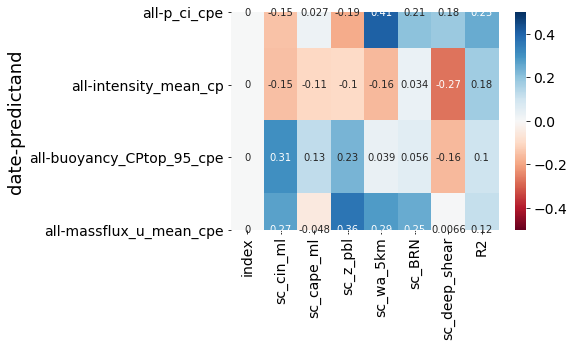

In [16]:
sns.heatmap(coeff[coeff.date=='all'].set_index(['date', 'predictand']), cmap = 'RdBu',vmin=-.5, vmax=.5, annot=True)

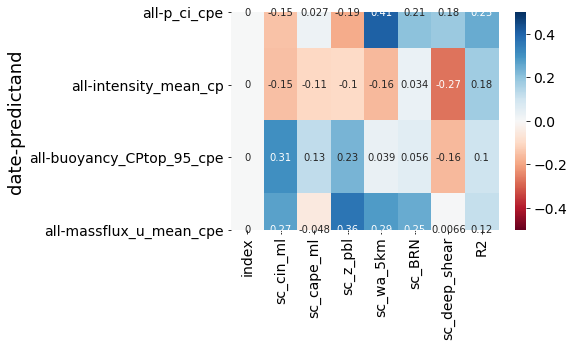

In [17]:
sns.heatmap(coeff[coeff.date=='all'].set_index(['date', 'predictand']), cmap = 'RdBu',vmin=-.5, vmax=.5, annot=True)

## general causal graph plotting (without data): 

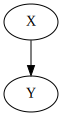

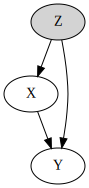

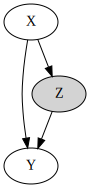

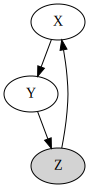

'../Figures/Dag_example_4.pdf'

In [18]:
dag = gv.Digraph(comment='Example1')
dag.node('X', 'X')
dag.node('Y', 'Y')
#dag.node('Z', 'Z')
dag.edges(['XY', ])

display(dag)
dag.render('../Figures/Dag_example_1')

dag = gv.Digraph(comment='Example1')
dag.node('X', 'X')
dag.node('Y', 'Y')
dag.node('Z', 'Z', style='filled')
dag.edges(['XY', 'ZX','ZY' ])
display(dag)
dag.render('../Figures/Dag_example_2')

dag = gv.Digraph(comment='Example1')
dag.node('X', 'X')
dag.node('Y', 'Y')
dag.node('Z', 'Z', style='filled')
dag.edges(['XY', 'XZ','ZY' ])
display(dag)
dag.render('../Figures/Dag_example_3')

dag = gv.Digraph(comment='Example1')
dag.node('X', 'X')
dag.node('Y', 'Y')
dag.node('Z', 'Z', style='filled')
dag.edges(['XY', 'ZX','YZ' ])
display(dag)
dag.render('../Figures/Dag_example_4')


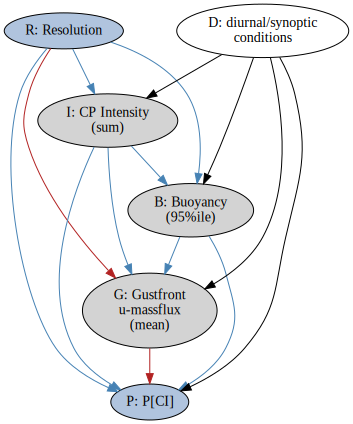

In [19]:
dag = gv.Digraph(comment='Cold pool resolution dependence')
dag.node('R', 'R: Resolution',style='filled', fillcolor='lightsteelblue')
dag.node('M', 'G: Gustfront  \nu-massflux \n(mean)', style='filled',)

dag.node('X', 'P: P[CI]',style='filled', fillcolor='lightsteelblue')
dag.node('I', 'I: CP Intensity \n(sum)', style='filled')
dag.node('B', 'B: Buoyancy \n(95%ile)', style='filled')
dag.node('D', 'D: diurnal/synoptic\nconditions')

dag.edges(['DM', 'DX', 'DI', 'DB', 
])

path1_col = 'firebrick'
path2_col = 'steelblue'
dag.edge('R', 'M', color=path1_col)
dag.edge('M', 'X', color=path1_col)
dag.edge('R', 'I', color=path2_col)
dag.edge('I', 'M', color=path2_col)
dag.edge('R', 'B', color=path2_col)
dag.edge('B', 'M', color=path2_col)
dag.edge('I', 'B', color=path2_col)
#dag.edge('M', 'X', color='blue')
dag.edge('B', 'X', color=path2_col)
dag.edge('I', 'X', color=path2_col)


dag.edge('R', 'X', color=path2_col, )
dag.render('../Figures/conceptual_causal_model_dag')
dag


# Causal analysis 

## Some functions for estimating causal effects + drawing graphs

In [205]:
def draw_graph(nodes, edges, estimates=None, multiple_estimates =False, proxy_cptype=False, proxy_gustfront=False, 
              show_pvalues=True, show_R2=False ):
    dag = gv.Digraph(comment='Cold pool resolution dependence')
    if show_R2: 
        if proxy_gustfront: 
            dag.node('G', 'G: Gust front\nProxy: %s\nR2=%.2f'%(proxy_gustfront, estimates[estimates.vertex=='RG']['R²'].values),  color='lightblue', style='filled')
        else:
            dag.node('G', 'G: Gust front',  color='lightblue', style='filled')
        if proxy_cptype:
            dag.node('I', 'I: CP type\nProxy: %s\nR2=%.2f'%(proxy_cptype, estimates[estimates.vertex=='RT']['R²'].values))
        else:
            dag.node('I', 'I: CP type')
        dag.node('P', 'P: P[CI]\nR2=%.2f'%(estimates[estimates.vertex=='RP']['R²'].values), style='filled', color='steelblue')
        dag.node('B', 'B: Buoyancy\nR2=%.2f'%(estimates[estimates.vertex=='RB']['R²'].values))
    else: 
        if proxy_gustfront: 
            dag.node('G', 'G: Gust front\nProxy: %s'%(proxy_gustfront),  color='lightblue', style='filled')
        else:
            dag.node('G', 'G: Gust front',  color='lightblue', style='filled')
        if proxy_cptype:
            dag.node('I', 'I: CP type\nProxy: %s'%(proxy_cptype))
        else:
            dag.node('I', 'I: CP type')
        dag.node('P', 'P: P[CI]', style='filled', color='steelblue')
        dag.node('B', 'B: Buoyancy')
    dag.node('R', 'R: Model resolution',style='filled', color='lightblue')
    dag.node('D', 'diurnal/synoptic\nconditions')
    if type(estimates) == pd.DataFrame:
        for edge in edges:
            if edge in estimates.vertex.values:
                if multiple_estimates:
                    est = ['%.2f'%val for val in estimates[estimates.vertex==edge].estimates.values]
                    dag.edge(edge[0], edge[1],label = '\n'.join(est))
                else:
                    if show_pvalues: 
                        label = '%.2f\np=%.2f'%(estimates[estimates.vertex==edge].estimates,estimates[estimates.vertex==edge].pvalues.values )
                        dag.edge(edge[0], edge[1],label = label)
                    else:
                        dag.edge(edge[0], edge[1],label = '%.2f'%(estimates[estimates.vertex==edge].estimates))
            else:
                dag.edge(edge[0], edge[1])    
    else:
        dag.edges(edges)
        
    return dag

def find_predictors(predictand, proxy_cptype, proxy_gustfront, inv_map_names, proxy_sc, use_sc_for_ri=True):
    #predictors = ['grid_size_num', proxy_sc]
    predictors =  ['grid_size_num']
    predictors.extend(proxy_sc)
    if predictand == inv_map_names[proxy_cptype]: 
        if use_sc_for_ri:
            pass
        else:
            predictors =[predictors[0]] # don't use proxy-sc
    elif predictand == inv_map_names[proxy_gustfront]:
        predictors.append('buoyancy_CPtop_95_cpe')
        predictors.append(proxy_cptype)
    elif predictand == 'B': 
        predictors.append(proxy_cptype)
    elif predictand == 'P': 
        predictors.append(proxy_cptype)
        predictors.append('buoyancy_CPtop_95_cpe')
        predictors.append(proxy_gustfront)
    else: 
        predictors = []
        logging.warning('For predictand %s no predictors defined!'%(predictand))
    return(predictors)




        

def wrapper_for_causal_effec_estimation( df, proxy_gustfront = 'massflux_u_mean_cpe', proxy_cptype ='intensity_sum_cp', 
    synoptic_variables = ['sc_cin_ml', 'sc_cape_ml',  'sc_z_pbl','sc_wa_5km', 'sc_deep_shear', 'sc_BRN'], N_sample= 1000, stratify_by=None,
    **kws):
    """
    wrapper_for_causal_effec_estimation computes the causal effects with bootstrapping and nicely formats the output.
    normalizes the data and then loops over N_sample and the variable given by "stratify_by" and then calculates the causal effect estimates.
    
    Parameters
    ----------
    df : [pandas dataframe], optional
        Dataframe containing all necessary variables, by default df
    proxy_gustfront : str, optional
        proxy variable for gustfront strength, by default 'massflux_u_mean_cpe'
    proxy_cptype : str, optional
        variable that should be used as proxy for cold pool type, by default 'intensity_sum_cp'
    synoptic_variables : list, optional
        variables to use for synoptic/largescale situation, by default ['sc_cin_ml', 'sc_cape_ml',  'sc_z_pbl','sc_wa_5km', 'sc_deep_shear', 'sc_BRN']
    N_sample : int, optional
        Number of samples to use for bootstrapping, by default 1000, but takes a while
    stratify_by : [type], optional
        Can either be ['days', 'time', 'resolution', None]. If none no stratification is applied, by default None
    **kws: 
        further keyword arguments that will be passed to estimate_causal_effects. 
        
    Returns
    --------
    Three pandas dataframes
    1) aggregated causal effect estimates (causal_effects)
    2) single estimated effects (estimates2)
    3) single estimated effects for synoptic variables (estimates_sc)
    
    """    
                                        
    egg = df[['intensity_mean_cp','intensity_sum_cp',
       #'hus_CPtop_mean_cp', 'theta_CPtop_mean_cp', 
          'buoyancy_CPtop_mean_cp',
       'n_gridpoints_cp', 'n_triggering_cp', 'time_num',
       'n_gridpoints_cpe', 'n_triggering_cpe', 'wa_95_cpe', #'hus_CPtop_95_cpe',
       #'theta_CPtop_95_cpe',
       'massflux_u_mean_cpe', 'massflux_u_sum_cpe', 'date_01', 'date_02', 'date_03', 'date_04', 
       'buoyancy_CPtop_95_cpe', 'p_ci_cp', 'p_ci_cpe', 'cp_radius','grid_size_num', 
       'sc_cin_ml', 'sc_cape_ml',  'sc_windspeed_1km',  'sc_windspeed_sfc', 'sc_z_pbl', 'sc_BRN', 'sc_deep_shear',
       'sc_thetav_1km',  'sc_thetav_sfc',  'sc_hus_sfc', 'sc_hus_1km' ,'sc_N2', 'sc_wa_5km']].dropna()
    
    norm_data = egg.apply(lambda x: (x - np.mean(x)) / (np.std(x) ))
    norm_data.describe()
    norm_data['date'] = df['date']
    norm_data['grid_size'] = df['grid_size']

    
    causal_effects=[]
    estimates2=[]
    estimates_sc2 = []
   
    if stratify_by=='resolution': 
        sel_categories =['156m-312m','156m-625m', '312m-625m', '156m-312m-\n625m' ]
    elif stratify_by=='days': 
        sel_categories = norm_data['date'].unique()
    elif stratify_by =='time':
        norm_data.columns
        q = norm_data.time_num.quantile(q =[.25,.5,.75],)
        norm_data['time_cat'] = norm_data.time_num
        norm_data.loc[norm_data.time_num <q[0.25], 'time_cat']=1
        norm_data.loc[norm_data.time_num >q[0.25], 'time_cat']=2
        norm_data.loc[norm_data.time_num >q[.5], 'time_cat']=3
        norm_data.loc[norm_data.time_num >q[.75], 'time_cat']=4
        sel_categories = [1,2,3,4]
    else: 
        sel_categories =['all']
    
    proxy_sc = synoptic_variables
    proxy_sc_str = 'sc_multiple'        
    
    for i_sample in tqdm(range(N_sample)): 
        for sel in sel_categories: 
            if stratify_by =='resolution':
                sel_res_idx = (norm_data.grid_size==sel[0:4] ) | (norm_data.grid_size == sel[5:9]) | (norm_data.grid_size == sel[11:18]) 
                norm_data_sel = norm_data[sel_res_idx]
            elif stratify_by=='days':
                norm_data_sel = norm_data[norm_data.date ==sel]
            elif stratify_by=='time':
                norm_data_sel = norm_data[norm_data.time_cat ==sel]
            else: norm_data_sel = norm_data
                
        

            N = len(norm_data_sel) 
            sample_data = norm_data_sel.sample(N, random_state=i_sample, replace=True)
            estimates, dag, nodes, edges, estimates_sc = estimate_causal_effects(sample_data,
                      proxy_cptype =[proxy_cptype], proxy_gustfront=[proxy_gustfront], proxy_sc = proxy_sc, return_single_sc=True, **kws)


            # set  values that dont fulfill pvalue criterion
            #estimates.loc[estimates.pvalues>.05, 'estimates'] = 0 #np.nan
            est = estimates.reset_index().set_index('vertex')['estimates']
            ce = pd.Series()
            ce['RP'] = est.RP
            ce['RGP'] = est.RG*est.GP
            ce['RIP'] = est.RI*est.IP
            ce['RIGP'] = est.RI*est.IG* est.GP
            ce['R*B*P'] = (est.RI*est.IB + est.RB)* (est.BG *est.GP + est.BP)
            ce.index.names = ['path']
            ce.name='causal_effect'
            ce = ce.reset_index()
            ce['proxy_cptype'] = proxy_cptype
            ce['proxy_gustfront'] = proxy_gustfront 
            ce['proxy_sc'] = proxy_sc_str 
            ce['proxy_all'] = proxy_gustfront +'_'+ proxy_cptype + '_' + proxy_sc_str
            ce['proxy_nosc'] = proxy_gustfront +'_'+ proxy_cptype 
            ce['i_sample'] = i_sample
            ce['selection'] = sel

            ce = ce.rename(columns={'index':'path'})
            causal_effects.append(ce)
            estimates['proxy_gustfront']=proxy_gustfront
            estimates['proxy_cptype']= proxy_cptype
            estimates['proxy_sc'] = proxy_sc_str
            estimates['proxy_all'] = proxy_gustfront +'_'+ proxy_cptype + '_' + proxy_sc_str
            estimates['proxy_nosc'] = proxy_gustfront +'_'+ proxy_cptype 
            estimates['i_sample'] = i_sample
            estimates['selection'] = sel
            estimates2.append(estimates)


            estimates_sc['proxy_gustfront']=proxy_gustfront
            estimates_sc['proxy_cptype']= proxy_cptype
            estimates_sc['proxy_sc'] = proxy_sc_str
            estimates_sc['proxy_all'] = proxy_gustfront +'_'+ proxy_cptype + '_' + proxy_sc_str
            estimates_sc['proxy_nosc'] = proxy_gustfront +'_'+ proxy_cptype 
            estimates_sc['i_sample'] = i_sample
            estimates_sc['selection'] = sel
            estimates_sc2.append(estimates_sc)


    estimates2 = pd.concat(estimates2)
    causal_effects = pd.concat(causal_effects)
    causal_effects['causal_effect_denorm'] = causal_effects['causal_effect']*(625.-156.)/egg['grid_size_num'].std() * egg.p_ci_cpe.std()

    estimates_sc = pd.concat(estimates_sc2)
    return causal_effects, estimates2, estimates_sc





def estimate_causal_effects(df, proxy_cptype =['intensity_mean_cp'], proxy_gustfront=['wa_95_cpe'], proxy_sc =['sc_thetav_1km'],
                            return_single_sc=False, use_sc_for_ri=True):
    if len(proxy_sc)>1: 
        proxy_sc_str = 'sc_multiple'
    else: 
        proxy_sc_str = proxy_sc[0]
    
    nodes = ['R', 'G', 'P', 'I', 'B', 'D']
    edges =['DG', 'DP', 'DI', 'DB', 'RG', 'GP', 'RI', 'IG', 'RB', 'BG', 'IB', 'BP', 'RP', 'IP']
    map_names = dict(R='grid_size_num', G = proxy_gustfront[0], P = 'p_ci_cpe',
                    I = proxy_cptype[0], D = proxy_sc_str, B= 'buoyancy_CPtop_95_cpe')
    inv_map_names = {v: k for k, v in map_names.items()}
    predictors_dict = {edge[1]: find_predictors(edge[1], proxy_cptype[0], proxy_gustfront[0], inv_map_names, proxy_sc, use_sc_for_ri=use_sc_for_ri) \
                       for edge in edges}
    
    # --- draw graph -------------------------------
    dag = draw_graph(nodes, edges)
    # --- next: estimate path coefficients via regression estimates
    estimates = pd.DataFrame(columns=['long_name', 'estimates', 'pvalues', 'vertex', 'R²','std'])
    estimates_sc = []
    for edge in edges: 
        if (edge not in estimates.vertex.values) & (not predictors_dict[edge[1]]==False): 
            predictand = map_names[edge[1]]
            predictors = predictors_dict[edge[1]]
            #logging.info('Predictand: %s\nPredictors: %s'%(predictand, ', '.join(predictors)))
            result = OLS(df[predictand], df[predictors]).fit()
            #print(edge)

            est = result.params
            est.name = 'estimates'
            est = pd.concat([est,result.pvalues, result.bse],axis=1,
                            keys = ['estimates', 'pvalues', 'std'])#.reset_index()
            if (len(proxy_sc)>1): 
                try: 
                    egg = est.loc[proxy_sc,:].sum()
                    sc_est_all = est.loc[proxy_sc,'estimates']
                    sc_est_all.name = 'estimates'
                    sc_est_all = sc_est_all.reset_index()
                    est = est.drop(proxy_sc)
                    est.loc[proxy_sc_str,:] = egg
                except:
                    est[proxy_sc_str] = np.nan
            vertices = [ inv_map_names[index] + inv_map_names[predictand] for index in est.index]
            
            est.index = [ est.index[i] +' -> ' + predictand for i in range(len(est.index))]
            
                       
            #print(est)
            est.name = 'estimates'
            est = est.reset_index()
            est = est.rename(columns={'index':'long_name'})
            est['vertex'] =vertices
            est['R²']= result.rsquared
            
            #print(est)
            estimates = pd.concat([estimates, est])
            if return_single_sc:
                sc_est_all['edge'] = edge
                estimates_sc.append(sc_est_all)
    # --- update graph with path coefficients
    #print(type(estimates))
    dag = draw_graph(nodes, edges, estimates=estimates)
    if return_single_sc: 
        estimates_sc = pd.concat(estimates_sc)
        return(estimates, dag, nodes, edges, estimates_sc)
    else:
        return(estimates,dag, nodes, edges)
            
        


# Test routine 

## Stratification by days
Here we test the robustness of the results by stratifying according to the 4 different days. 

In [208]:
causal_effects, estimates2, estimates_sc = wrapper_for_causal_effec_estimation(df, N_sample=1000,stratify_by='days',
                                proxy_gustfront='massflux_u_mean_cpe', proxy_cptype ='intensity_sum_cp',)
                                #synoptic_variables = ['sc_cin_ml', 'sc_cape_ml',  'sc_z_pbl','sc_wa_5km'])

100%|██████████| 1000/1000 [10:27<00:00,  1.25it/s]


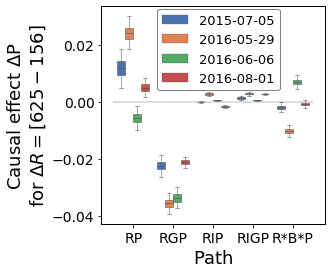

In [209]:
fig = plt.figure(figsize=[4,4])

ax0 = sns.boxplot(data = causal_effects, x ='path', y ='causal_effect_denorm', sym='', hue = 'selection', palette = secondary_colors[:4], linewidth=.5, 
                  whis=[2.5,97.5], saturation=1)
leg = ax0.legend(bbox_to_anchor=(.25, .99), loc=2, borderaxespad=0.,fontsize=13 )
leg.get_frame().set_alpha(0.5)
plt.hlines(0,-.5,4.5, color ='lightgrey')
plt.ylabel(r'Causal effect $\Delta$P'+'\n'+r'for $\Delta R= [625-156] $')
plt.xlabel('Path')
fig.savefig('../Figures/agg_path_causal_effects_denormalized_days.svg')

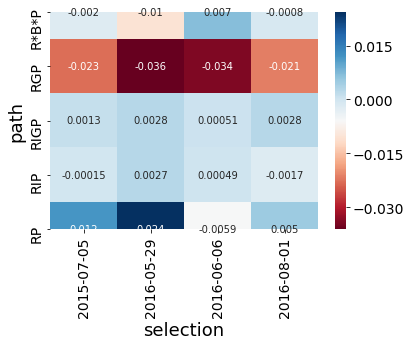

In [23]:
spam = causal_effects.groupby(['path', 'selection']).mean().unstack('selection')

sns.heatmap(spam['causal_effect_denorm'], annot=True, cmap='RdBu')

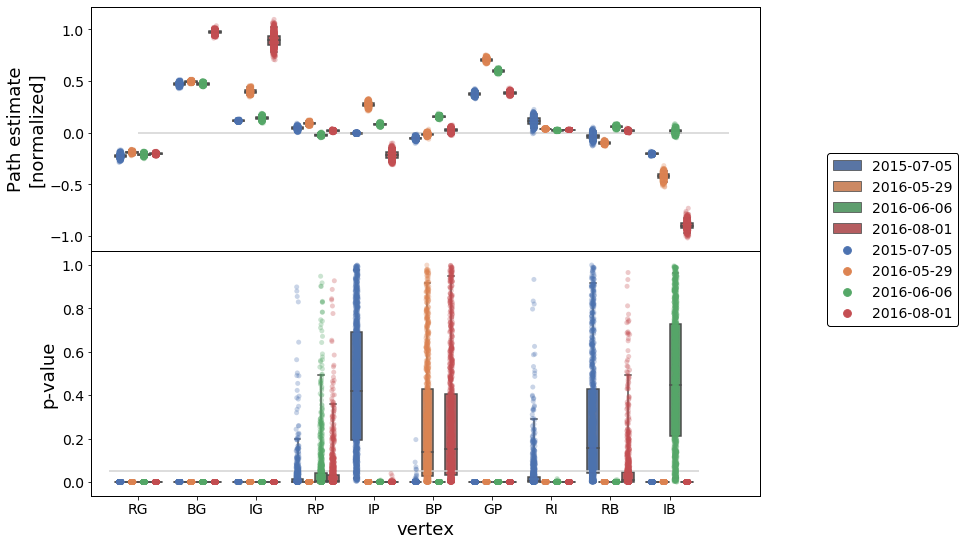

<Figure size 432x288 with 0 Axes>

In [210]:
sel_paths = ['RG', 'BG', 'IG', 'RP', 'IP', 'BP', 'GP', 'RI', 
       'RB', 'IB']
kws_points = dict( alpha=.3, hue = 'selection', palette = secondary_colors[:4], dodge=True)
kws_bulk = dict( sym = '',hue = 'selection', palette = secondary_colors[:4], whis=[2.5,97.5] )
estimates2_sel =estimates2.set_index('vertex').loc[sel_paths].reset_index()

fig, axs= plt.subplots(nrows=2,ncols=1, figsize=[12,9], sharex=True)
axs=axs.ravel()
i = 0
plt.figure()

sns.stripplot(data =estimates2_sel, x = 'vertex', y = 'estimates',ax = axs[i], **kws_points)
#sns.pointplot(data =estimates2_sel, x = 'vertex', y = 'pvalues',  alpha=.3, legend=False, join=False, capsize=.2, ax = axs[i])
sns.boxplot(data =estimates2_sel, x = 'vertex', y = 'estimates',   ax = axs[i], **kws_bulk)
axs[i].hlines(0,0,10,color ='lightgrey')
axs[i].set_ylabel('Path estimate\n[normalized]')
#plt.ylim([-.5,0.9]) 
axs[i].set_xlabel('Path ')
axs[i].legend().remove()

i+=1

sns.stripplot(data =estimates2_sel, x = 'vertex', y = 'pvalues',ax = axs[i], **kws_points)
#sns.pointplot(data =estimates2_sel, x = 'vertex', y = 'pvalues',  alpha=.3, legend=False, join=False, capsize=.2, ax = axs[i])
sns.boxplot(data =estimates2_sel, x = 'vertex', y = 'pvalues',   ax = axs[i], **kws_bulk)
axs[i].set_ylabel('p-value')

axs[i].hlines(0.05,-0.5,9.5,color ='lightgrey')
#plt.ylim([0,0.07])     
axs[i].legend(bbox_to_anchor=(1.1, 1.4), loc=2, borderaxespad=0.)
fig.subplots_adjust(hspace=.0, wspace=.175)
fig.savefig('../Figures/single_path_causal_effects_normalized_pvalues_days.pdf')

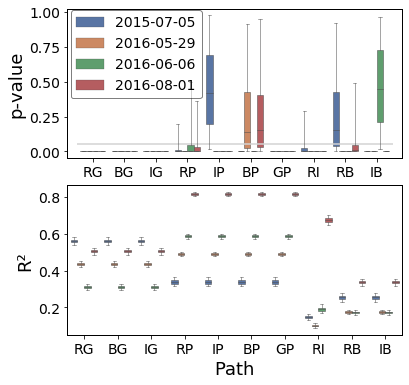

In [211]:
sel_paths = ['RG', 'BG', 'IG', 'RP', 'IP', 'BP', 'GP', 'RI', 
       'RB', 'IB']
kws_points = dict( alpha=.3, color = 'black')
kws_bulk = dict(sym = '', hue='selection', palette = secondary_colors[:4], linewidth=.5, whis=[2.5,97.5],)
estimates2_sel =estimates2.set_index('vertex').loc[sel_paths].reset_index()

fig, axs= plt.subplots(nrows=2,ncols=1, figsize=[6,6], sharex=False, gridspec_kw={'height_ratios': [1,1]})
axs=axs.ravel()
i = 0


#sns.stripplot(data =estimates2_sel, x = 'vertex', y = 'pvalues',ax = axs[i], **kws_points)
#sns.pointplot(data =estimates2_sel, x = 'vertex', y = 'pvalues',  alpha=.3, legend=False, join=False, capsize=.2, ax = axs[i])
sns.boxplot(data =estimates2_sel, x = 'vertex', y = 'pvalues',   ax = axs[i], **kws_bulk)
axs[i].set_ylabel('p-value')

axs[i].hlines(0.05,-0.5,9.5,color ='lightgrey')
#plt.ylim([0,0.07])
axs[i].legend().remove()

i+=1

#sns.stripplot(data =estimates2_sel, x = 'vertex', y = 'R²',ax = axs[i], **kws_points)
#sns.pointplot(data =estimates2_sel, x = 'vertex', y = 'pvalues',  alpha=.3, legend=False, join=False, capsize=.2, ax = axs[i])
sns.boxplot(data =estimates2_sel, x = 'vertex', y = 'R²',   ax = axs[i], **kws_bulk)
axs[i].set_ylabel('R²')

#axs[i].hlines(0.05,-0.5,9.5,color ='lightgrey')
#plt.ylim([0,0.07])     
axs[i].set_xlabel('Path')
axs[i].legend().remove()
leg = axs[0].legend(bbox_to_anchor=(.01, .99), loc=2, borderaxespad=0., )
leg.get_frame().set_alpha(0.5)
fig.subplots_adjust(hspace=.18, wspace=.175)
fig.savefig('../Figures/single_path_causal_effects_normalized_pvalues_days.pdf')
fig.savefig('../Figures/single_path_causal_effects_normalized_pvalues_days.svg')


## sampling time of day 

In [26]:
causal_effects, estimates2, estimates_sc = wrapper_for_causal_effec_estimation(df, N_sample=1000,stratify_by='time',
                                proxy_gustfront='massflux_u_mean_cpe', proxy_cptype ='intensity_sum_cp')
                                #synoptic_variables = ['sc_cin_ml', 'sc_cape_ml',  'sc_z_pbl','sc_wa_5km'])

  0%|          | 0/1000 [00:00<?, ?it/s]/software/opt/bionic/x86_64/python/3.7-2019.07/lib/python3.7/site-packages/ipykernel_launcher.py:120: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

100%|██████████| 1000/1000 [10:19<00:00,  1.61it/s]


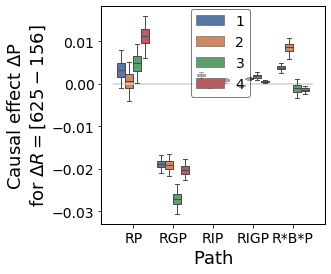

In [27]:
import matplotlib
matplotlib.rcParams['lines.markeredgewidth'] = 0.1
fig = plt.figure(figsize=[4,4])
#ax = sns.pointplot(data = causal_effects, x ='path', y ='causal_effect_denorm', hue ='proxy_nosc',  dodge=False, #jitter=.3,
#              palette='colorblind', join=False, capsize=.3)

ax0 = sns.boxplot(data = causal_effects, x ='path', y ='causal_effect_denorm', sym='', hue = 'selection', palette = secondary_colors[:4], linewidth=1, whis=[2.5,97.5])
leg = ax0.legend(bbox_to_anchor=(.4, .99), loc=2, borderaxespad=0., )
leg.get_frame().set_alpha(0.5)
#ax = sns.stripplot(data = causal_effects, x ='path', y ='causal_effect_denorm',hue ='except_date' , dodge=True, palette = secondary_colors[:4],#jitter=.3,
#              alpha = .2)
plt.hlines(0,-.5,4.5, color ='lightgrey')
plt.ylabel(r'Causal effect $\Delta$P'+'\n'+r'for $\Delta R= [625-156] $')
plt.xlabel('Path')
y0 = -.025
y1 = .015
#plt.ylim([-0.05,0.05])
#ax.legend(bbox_to_anchor=(1.1, 1), loc=2, borderaxespad=0.)
fig.savefig('../Figures/agg_path_causal_effects_denormalized_time.pdf')

## sampling model resolutions

In [28]:
causal_effects, estimates2, estimates_sc = wrapper_for_causal_effec_estimation(df, N_sample=1000,stratify_by='resolution',
                                proxy_gustfront='massflux_u_mean_cpe', proxy_cptype ='intensity_sum_cp',
                                synoptic_variables = ['sc_cin_ml', 'sc_cape_ml',  'sc_z_pbl','sc_wa_5km'])

  0%|          | 0/1000 [00:00<?, ?it/s]/software/opt/bionic/x86_64/python/3.7-2019.07/lib/python3.7/site-packages/ipykernel_launcher.py:120: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

100%|██████████| 1000/1000 [12:36<00:00,  1.33it/s]


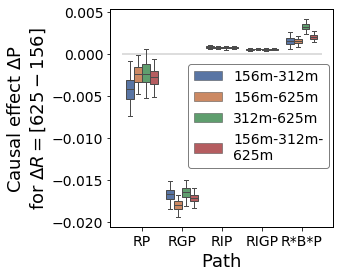

In [29]:
import matplotlib
matplotlib.rcParams['lines.markeredgewidth'] = 0.1
fig = plt.figure(figsize=[4,4])
#ax = sns.pointplot(data = causal_effects, x ='path', y ='causal_effect_denorm', hue ='proxy_nosc',  dodge=False, #jitter=.3,
#              palette='colorblind', join=False, capsize=.3)

ax0 = sns.boxplot(data = causal_effects, x ='path', y ='causal_effect_denorm', sym='', hue = 'selection', palette = secondary_colors[:4], linewidth=1, whis=[2.5,97.5])
leg = ax0.legend(bbox_to_anchor=(.35, .75), loc=2, borderaxespad=0., )
leg.get_frame().set_alpha(0.5)
#ax = sns.stripplot(data = causal_effects, x ='path', y ='causal_effect_denorm',hue ='except_date' , dodge=True, palette = secondary_colors[:4],#jitter=.3,
#              alpha = .2)
plt.hlines(0,-.5,4.5, color ='lightgrey')
plt.ylabel(r'Causal effect $\Delta$P'+'\n'+r'for $\Delta R= [625-156] $')
plt.xlabel('Path')
y0 = -.025
y1 = .015
#ax.legend(bbox_to_anchor=(1.1, 1), loc=2, borderaxespad=0.)
fig.savefig('../Figures/agg_path_causal_effects_denormalized_res.pdf')

## No stratification (just random sampling)
**This corresponds to the first causal result of the paper**

In [212]:
causal_effects, estimates2, estimates_sc = wrapper_for_causal_effec_estimation(df, N_sample=1000,stratify_by=None,
                                proxy_gustfront='massflux_u_mean_cpe', proxy_cptype ='intensity_sum_cp',)
                                

100%|██████████| 1000/1000 [03:47<00:00,  4.44it/s]


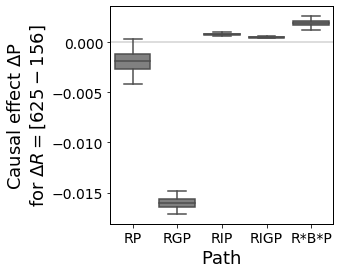

In [213]:
import matplotlib
matplotlib.rcParams['lines.markeredgewidth'] = 0.1
fig = plt.figure(figsize=[4,4])

ax = sns.boxplot(data = causal_effects, x ='path', y ='causal_effect_denorm', sym='', color = 'grey',saturation=.4, whis=[2.5,97.5])

plt.hlines(0,-.5,4.5, color ='lightgrey')
plt.ylabel(r'Causal effect $\Delta$P'+'\n'+r'for $\Delta R= [625-156] $')
plt.xlabel('Path')
fig.savefig('../Figures/agg_path_causal_effects_denormalized.pdf')

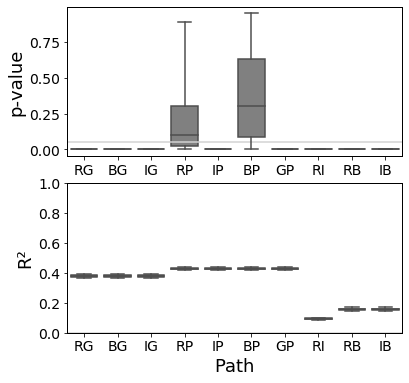

In [215]:
sel_paths = ['RG', 'BG', 'IG', 'RP', 'IP', 'BP', 'GP', 'RI', 
       'RB', 'IB']
kws_points = dict( alpha=.3, color = 'black', whis=[2.5,97.5])
kws_bulk = dict(color = 'grey', saturation=.4, sym = '', whis=[2.5,97.5])
estimates2_sel =estimates2.set_index('vertex').loc[sel_paths].reset_index()

fig, axs= plt.subplots(nrows=2,ncols=1, figsize=[6,6], sharex=False, gridspec_kw={'height_ratios': [ 1,1]})
axs=axs.ravel()
i = 0
#sns.stripplot(data =estimates2_sel, x = 'vertex', y = 'pvalues',ax = axs[i], **kws_points)
#sns.pointplot(data =estimates2_sel, x = 'vertex', y = 'pvalues',  alpha=.3, legend=False, join=False, capsize=.2, ax = axs[i])
sns.boxplot(data =estimates2_sel, x = 'vertex', y = 'pvalues',   ax = axs[i], **kws_bulk)
axs[i].set_ylabel('p-value')

axs[i].hlines(0.05,-0.5,9.5,color ='lightgrey')
#plt.ylim([0,0.07])     

i+=1

#sns.stripplot(data =estimates2_sel, x = 'vertex', y = 'R²',ax = axs[i], **kws_points)
#sns.pointplot(data =estimates2_sel, x = 'vertex', y = 'pvalues',  alpha=.3, legend=False, join=False, capsize=.2, ax = axs[i])
sns.boxplot(data =estimates2_sel, x = 'vertex', y = 'R²',   ax = axs[i], **kws_bulk)
axs[i].set_ylabel('R²')

axs[i].hlines(0.0,-0.5,9.5,color ='lightgrey')
#plt.ylim([0,0.07])   
axs[i].set_ylim([0,1])
axs[i].set_xlabel('Path')

fig.subplots_adjust(hspace=.18, wspace=.175)
fig.savefig('../Figures/single_path_causal_effects_normalized_pvalues.svg')

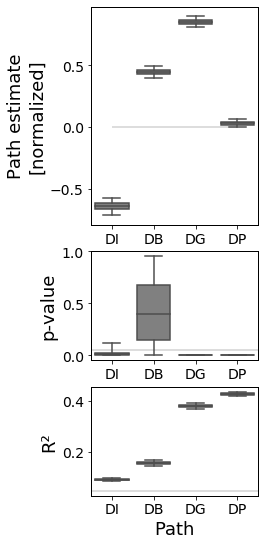

<Figure size 432x288 with 0 Axes>

In [216]:
sel_paths = ['DI',  'DB', 'DG', 'DP']
kws_points = dict( alpha=.3, color = 'black', whis=[2.5,97.5])
kws_bulk = dict(color = 'grey', saturation=.4, sym = '', whis=[2.5,97.5])
estimates2_sel =estimates2.set_index('vertex').loc[sel_paths].reset_index()

fig, axs= plt.subplots(nrows=3,ncols=1, figsize=[3,9], sharex=False, gridspec_kw={'height_ratios': [2, 1,1]})
axs=axs.ravel()
i = 0
plt.figure()
#sns.stripplot(data =estimates2_sel, x = 'vertex', y = 'estimates',ax = axs[i], **kws_points)
#sns.pointplot(data =estimates2_sel, x = 'vertex', y = 'pvalues',  alpha=.3, legend=False, join=False, capsize=.2, ax = axs[i])
sns.boxplot(data =estimates2_sel, x = 'vertex', y = 'estimates',   ax = axs[i], **kws_bulk)
axs[i].hlines(0,0,3,color ='lightgrey')
axs[i].set_ylabel('Path estimate\n[normalized]')
#plt.ylim([-.5,0.9]) 
axs[i].set_xlabel('Path ')


i+=1

#sns.stripplot(data =estimates2_sel, x = 'vertex', y = 'pvalues',ax = axs[i], **kws_points)
#sns.pointplot(data =estimates2_sel, x = 'vertex', y = 'pvalues',  alpha=.3, legend=False, join=False, capsize=.2, ax = axs[i])
sns.boxplot(data =estimates2_sel, x = 'vertex', y = 'pvalues',   ax = axs[i], **kws_bulk)
axs[i].set_ylabel('p-value')

axs[i].hlines(0.05,-0.5,3.5,color ='lightgrey')
#plt.ylim([0,0.07])     

i+=1

#sns.stripplot(data =estimates2_sel, x = 'vertex', y = 'R²',ax = axs[i], **kws_points)
#sns.pointplot(data =estimates2_sel, x = 'vertex', y = 'pvalues',  alpha=.3, legend=False, join=False, capsize=.2, ax = axs[i])
sns.boxplot(data =estimates2_sel, x = 'vertex', y = 'R²',   ax = axs[i], **kws_bulk)
axs[i].set_ylabel('R²')

axs[i].hlines(0.05,-0.5,3.5,color ='lightgrey')
#plt.ylim([0,0.07])     
axs[i].set_xlabel('Path')

fig.subplots_adjust(hspace=.18, wspace=.175)
fig.savefig('../Figures/single_path_causal_effects_normalized_pvalues_D.pdf')

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text xticklabel objects>)

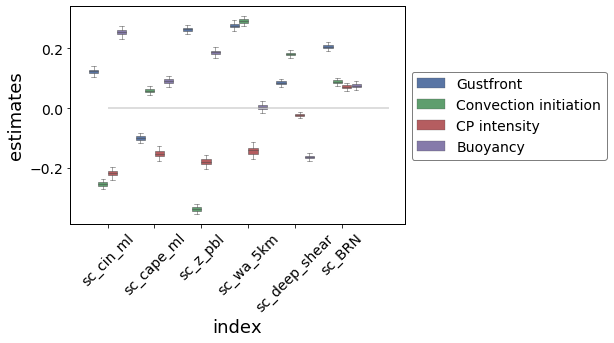

In [34]:
estimates_sc.loc[estimates_sc.edge =='DG', 'edge'] = 'Gustfront'
estimates_sc.loc[estimates_sc.edge =='DB', 'edge'] = 'Buoyancy'
estimates_sc.loc[estimates_sc.edge =='DI', 'edge'] = 'CP intensity'
estimates_sc.loc[estimates_sc.edge =='DP', 'edge'] = 'Convection initiation'

sns.boxplot(data = estimates_sc, hue = 'edge', y = 'estimates',x ='index', linewidth=.5, sym ='', whis=[2.5,97.5])
plt.gca().hlines(0.0,0,6,color ='lightgrey')
leg = plt.legend(bbox_to_anchor=(1.02, .7), loc=2, borderaxespad=0.)
leg.get_frame().set_alpha(0.5)
plt.xticks(rotation=45)

### Draw causal graph with data of random sampling

In [26]:
path1_col = 'firebrick'
path2_col = 'steelblue'
nodes = ['R', 'G', 'P', 'I', 'B', 'D']
edges =['DG', 'DP', 'DI', 'DB', 'RG', 'GP', 'RI', 'IG', 'RB', 'BG', 'IB', 'BP', 'RP', 'IP']
def draw_graph_2(nodes, edges, estimates=None, multiple_estimates =False, proxy_cptype=False, proxy_gustfront=False, 
              show_pvalues=True, show_R2=False ):
    # includes thickness of lines
    dag = gv.Digraph(comment='Cold pool resolution dependence')
    if show_R2: 
        if proxy_gustfront: 
            dag.node('G', 'G: Gust front\nProxy: %s\nR2=%.2f'%(proxy_gustfront, estimates[estimates.vertex=='RG']['R²'].values),  fillcolor='lightsteelblue', style='filled')
        else:
            dag.node('G', 'G: Gustfront\nu-massflux\n(mean)',  style='filled')
        if proxy_cptype:
            dag.node('I', 'I: CP intensity\nProxy: %s\nR2=%.2f'%(proxy_cptype, estimates[estimates.vertex=='RT']['R²'].values),  style='filled')
        else:
            dag.node('I', 'I: CP intensity\n(sum)',  style='filled')
        dag.node('P', 'P: P[CI]\nR2=%.2f'%(estimates[estimates.vertex=='RP']['R²'].values), style='filled', fillcolor='lightsteelblue')
        dag.node('B', 'B: Buoyancy\nR2=%.2f'%(estimates[estimates.vertex=='RB']['R²'].values),  style='filled')
    else: 
        if proxy_gustfront: 
            dag.node('G', 'G: Gust front\nProxy: %s'%(proxy_gustfront),  style='filled')
        else:
            dag.node('G', 'G: Gustfront\nu-massflux\n(mean)',  style='filled')
        if proxy_cptype:
            dag.node('I', 'I: CP intensity\nProxy: %s'%(proxy_cptype),  style='filled')
        else:
            dag.node('I', 'I: CP intensity\n(sum)',  style='filled')
        dag.node('P', 'P: P[CI]', style='filled', fillcolor='lightsteelblue')
        dag.node('B', 'B: Buoyancy\n(95%ile)',  style='filled')
    dag.node('R', 'R: Resolution',style='filled', fillcolor='lightsteelblue')
    dag.node('D', 'D: diurnal/synoptic\nconditions')
    if type(estimates) == pd.DataFrame:
        for edge in edges:
            if edge in estimates.vertex.values:
                est = estimates[estimates.vertex==edge].estimates.values
                if edge[0]=='D': 
                    color = 'grey'
                elif est > 0.01:
                    color = path2_col
                elif est < -0.01:
                    color =path1_col
                else: color = 'black'
                if multiple_estimates:
                    est = ['%.2f'%val for val in estimates[estimates.vertex==edge].estimates.values]
                    dag.edge(edge[0], edge[1],label = '\n'.join(est))
                else:
                    if show_pvalues: 
                        label = '%.2f\np=%.2f'%(estimates[estimates.vertex==edge].estimates,estimates[estimates.vertex==edge].pvalues.values )
                        dag.edge(edge[0], edge[1],label = label)
                    else:
                        dag.edge(edge[0], edge[1],label = '%.2f'%(estimates[estimates.vertex==edge].estimates), color = color)
                        #ag.edge_attr({'penwidth':.4})
            else:
                dag.edge(edge[0], edge[1])    
    else:
        dag.edges(edges)
        
    return dag

In [27]:

#dag = draw_graph(nodes, edges, estimates=estimates, multiple_estimates=True)
#display(dag)
estimates2_sel =estimates2.groupby('vertex').mean().reset_index()
dag = draw_graph_2(nodes, edges, estimates = estimates2_sel , multiple_estimates=False, show_pvalues=False)
dag.render('testdag',)

with open("testdag", "r+", ) as f:
    text = f.read().split('\n') # read everything in the file
    for vertex in  estimates2_sel.vertex:
        path_str = vertex[0] + ' -> ' + vertex[1]
        estimate = estimates2_sel.set_index('vertex').loc[vertex].estimates
        minimum = .5
        replacement_str = ' penwidth=%.2f]'%(max([(np.abs(estimate)*10), minimum]))
        text = [line.replace(']', replacement_str) if line.find(path_str)>0 else line for line in text ]
    text = [line.replace(']', ' rank="sink"]') if line.find('G: Gust front')>0 else line for line in text ]
    with open ('DAG_path_estimates_colored_sized', 'w') as f2: 
        f2.write('\n'.join(text)) 


In [28]:
print('\n'.join(text))

// Cold pool resolution dependence
digraph {
	G [label="G: Gustfront
u-massflux
(mean)" style=filled]
	I [label="I: CP intensity
(sum)" style=filled]
	P [label="P: P[CI]" fillcolor=lightsteelblue style=filled]
	B [label="B: Buoyancy
(95%ile)" style=filled]
	R [label="R: Resolution" fillcolor=lightsteelblue style=filled]
	D [label="D: diurnal/synoptic
conditions"]
	D -> G [label=0.85 color=grey penwidth=8.55]
	D -> P [label=0.03 color=grey penwidth=0.50]
	D -> I [label=-0.64 color=grey penwidth=6.41]
	D -> B [label=0.45 color=grey penwidth=4.49]
	R -> G [label=-0.13 color=firebrick penwidth=1.35]
	G -> P [label=0.45 color=steelblue penwidth=4.46]
	R -> I [label=0.05 color=steelblue penwidth=0.50]
	I -> G [label=0.09 color=steelblue penwidth=0.86]
	R -> B [label=0.04 color=steelblue penwidth=0.50]
	B -> G [label=0.54 color=steelblue penwidth=5.42]
	I -> B [label=-0.24 color=firebrick penwidth=2.44]
	B -> P [label=-0.00 color=black penwidth=0.50]
	R -> P [label=-0.01 color=black penwidth=

In [29]:
import subprocess
#p = subprocess.Popen('neato -T png DAG_path_estimates_colored_sized > ../Figures/DAG_path_estimates_colored_sized.png', shell=True,)
p = subprocess.Popen('dot -Tpng DAG_path_estimates_colored_sized > ../Figures/DAG_path_estimates_colored_sized.png', shell=True,)
p = subprocess.Popen('dot -Tps2 DAG_path_estimates_colored_sized > ../Figures/DAG_path_estimates_colored_sized.ps', shell=True,)
p = subprocess.Popen('dot -Tps2 DAG_path_estimates_colored_sized > ../Figures/DAG_path_estimates_colored_sized.ps', shell=True,)



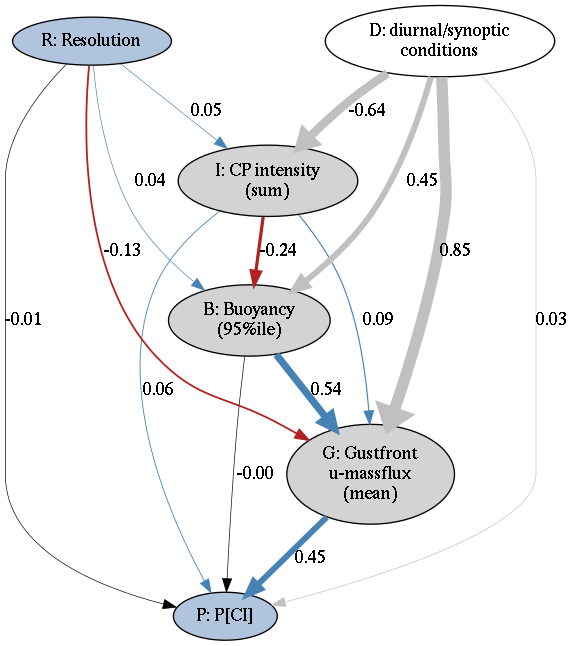

In [30]:

Image('../Figures/DAG_path_estimates_colored_sized.png')


## Compare sc for ri 
Compare whether synoptic conditions have an impact on the causal effect of Resolution-Intensity. 

In [31]:
causal_effects, estimates2, estimates_sc = wrapper_for_causal_effec_estimation(df, N_sample=1000,
                                proxy_gustfront='massflux_u_mean_cpe', proxy_cptype ='intensity_sum_cp',)
estimates2_with_sc = estimates2

causal_effects, estimates2, estimates_sc = wrapper_for_causal_effec_estimation(df, N_sample=1000,
                                proxy_gustfront='massflux_u_mean_cpe', proxy_cptype ='intensity_sum_cp', use_sc_for_ri =False)

ri_sc = estimates2_with_sc[estimates2_with_sc.vertex=='RI']['estimates']
ri_nosc = estimates2[estimates2.vertex=='RI']['estimates']

  0%|          | 0/1000 [00:00<?, ?it/s]/software/opt/bionic/x86_64/python/3.7-2019.07/lib/python3.7/site-packages/ipykernel_launcher.py:120: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  0%|          | 0/1000 [00:00<?, ?it/s]/software/opt/bionic/x86_64/python/3.7-2019.07/lib/python3.7/site-packages/ipykernel_launcher.py:120: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

100%|██████████| 1000/1000 [02:57<00:00,  5.63it/s]


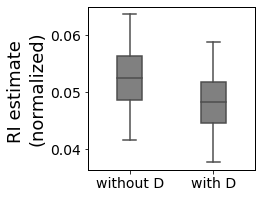

In [32]:
egg = pd.DataFrame()
egg['without D'] = ri_nosc
egg['with D'] = ri_sc
fig = plt.figure(figsize=[3,3])
sns.boxplot(data =egg, color='grey', sym = '', width=.3, whis=[2.5,97.5])
plt.ylabel('RI estimate \n(normalized)')
fig.savefig('../Figures/comparison_RI_with_without_D.pdf')

## Use different variables
- change proxy for gustfront, cold pool strength and synoptic variables

  0%|          | 0/1000 [00:00<?, ?it/s]/software/opt/bionic/x86_64/python/3.7-2019.07/lib/python3.7/site-packages/ipykernel_launcher.py:120: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

100%|██████████| 1000/1000 [03:12<00:00,  5.26it/s]


Text(0.5, 1.0, 'massflux_u_mean_cpe - intensity_mean_cp')

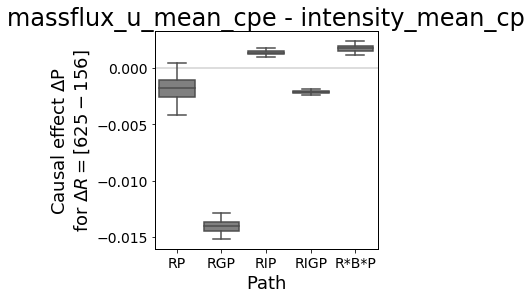

In [33]:
causal_effects, estimates2, estimates_sc = wrapper_for_causal_effec_estimation(df,proxy_gustfront='massflux_u_mean_cpe', 
                                                                               proxy_cptype ='intensity_mean_cp',)
fig = plt.figure(figsize=[4,4])

ax = sns.boxplot(data = causal_effects, x ='path', y ='causal_effect_denorm', sym='', color = 'grey',saturation=.4, whis=[2.5,97.5])

plt.hlines(0,-.5,4.5, color ='lightgrey')
plt.ylabel(r'Causal effect $\Delta$P'+'\n'+r'for $\Delta R= [625-156] $')
plt.xlabel('Path')
plt.title('massflux_u_mean_cpe - intensity_mean_cp')

  0%|          | 0/1000 [00:00<?, ?it/s]/software/opt/bionic/x86_64/python/3.7-2019.07/lib/python3.7/site-packages/ipykernel_launcher.py:120: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

100%|██████████| 1000/1000 [03:11<00:00,  5.21it/s]


Text(0.5, 1.0, 'massflux_u_mean_cpe - cp_radius')

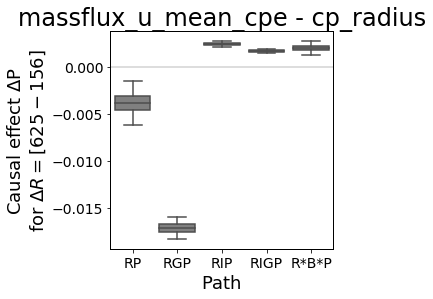

In [34]:
causal_effects, estimates2, estimates_sc = wrapper_for_causal_effec_estimation(df, N_sample=1000,
                                proxy_gustfront='massflux_u_mean_cpe', proxy_cptype ='cp_radius',)

fig = plt.figure(figsize=[4,4])

ax = sns.boxplot(data = causal_effects, x ='path', y ='causal_effect_denorm', sym='', color = 'grey',saturation=.4, whis=[2.5,97.5])

plt.hlines(0,-.5,4.5, color ='lightgrey')
plt.ylabel(r'Causal effect $\Delta$P'+'\n'+r'for $\Delta R= [625-156] $')
plt.xlabel('Path')
plt.title('massflux_u_mean_cpe - cp_radius')

  0%|          | 0/1000 [00:00<?, ?it/s]/software/opt/bionic/x86_64/python/3.7-2019.07/lib/python3.7/site-packages/ipykernel_launcher.py:120: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

100%|██████████| 1000/1000 [03:11<00:00,  5.27it/s]


Text(0.5, 1.0, 'wa_95_cpe - intensity_sum_cp')

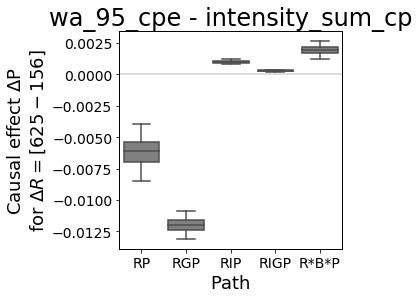

In [35]:
causal_effects, estimates2, estimates_sc = wrapper_for_causal_effec_estimation(df, N_sample=1000,
                                proxy_gustfront='wa_95_cpe', proxy_cptype ='intensity_sum_cp',)

fig = plt.figure(figsize=[4,4])

ax = sns.boxplot(data = causal_effects, x ='path', y ='causal_effect_denorm', sym='', color = 'grey',saturation=.4, whis=[2.5,97.5])

plt.hlines(0,-.5,4.5, color ='lightgrey')
plt.ylabel(r'Causal effect $\Delta$P'+'\n'+r'for $\Delta R= [625-156] $')
plt.xlabel('Path')
plt.title('wa_95_cpe - intensity_sum_cp')

  0%|          | 0/1000 [00:00<?, ?it/s]/software/opt/bionic/x86_64/python/3.7-2019.07/lib/python3.7/site-packages/ipykernel_launcher.py:120: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

100%|██████████| 1000/1000 [02:55<00:00,  5.79it/s]


Text(0.5, 0, 'Path')

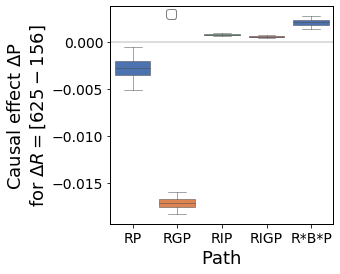

In [36]:
causal_effects, estimates2, estimates_sc = wrapper_for_causal_effec_estimation(df, N_sample=1000,
                                proxy_gustfront='massflux_u_mean_cpe', proxy_cptype ='intensity_sum_cp',
                                synoptic_variables = ['sc_cin_ml', 'sc_cape_ml',  'sc_z_pbl','sc_wa_5km'])
fig = plt.figure(figsize=[4,4])
ax0 = sns.boxplot(data = causal_effects, x ='path', y ='causal_effect_denorm', sym='', palette = secondary_colors[:4], linewidth=.5, 
                  whis=[2.5,97.5], saturation=1)
leg = ax0.legend(bbox_to_anchor=(.25, .99), loc=2, borderaxespad=0.,fontsize=13 )
leg.get_frame().set_alpha(0.5)
plt.hlines(0,-.5,4.5, color ='lightgrey')
plt.ylabel(r'Causal effect $\Delta$P'+'\n'+r'for $\Delta R= [625-156] $')
plt.xlabel('Path')

  0%|          | 0/1000 [00:00<?, ?it/s]/software/opt/bionic/x86_64/python/3.7-2019.07/lib/python3.7/site-packages/ipykernel_launcher.py:120: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

100%|██████████| 1000/1000 [02:40<00:00,  6.41it/s]


Text(0.5, 0, 'Path')

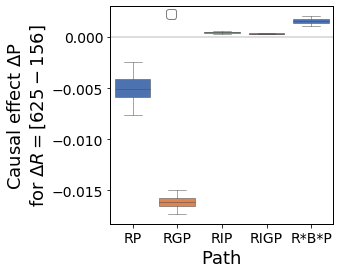

In [37]:
causal_effects, estimates2, estimates_sc = wrapper_for_causal_effec_estimation(df, N_sample=1000,
                                proxy_gustfront='massflux_u_mean_cpe', proxy_cptype ='intensity_sum_cp',
                                synoptic_variables = ['sc_cin_ml', 'sc_cape_ml'])
fig = plt.figure(figsize=[4,4])
ax0 = sns.boxplot(data = causal_effects, x ='path', y ='causal_effect_denorm', sym='', palette = secondary_colors[:4], linewidth=.5, 
                  whis=[2.5,97.5], saturation=1)
leg = ax0.legend(bbox_to_anchor=(.25, .99), loc=2, borderaxespad=0.,fontsize=13 )
leg.get_frame().set_alpha(0.5)
plt.hlines(0,-.5,4.5, color ='lightgrey')
plt.ylabel(r'Causal effect $\Delta$P'+'\n'+r'for $\Delta R= [625-156] $')
plt.xlabel('Path')

  0%|          | 0/1000 [00:00<?, ?it/s]/software/opt/bionic/x86_64/python/3.7-2019.07/lib/python3.7/site-packages/ipykernel_launcher.py:120: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

100%|██████████| 1000/1000 [02:52<00:00,  5.89it/s]


Text(0.5, 0, 'Path')

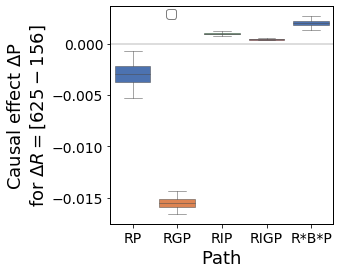

In [38]:
causal_effects, estimates2, estimates_sc = wrapper_for_causal_effec_estimation(df, N_sample=1000,
                                proxy_gustfront='massflux_u_mean_cpe', proxy_cptype ='intensity_sum_cp',
                                synoptic_variables = [ 'sc_z_pbl','sc_wa_5km', 'sc_deep_shear', 'sc_BRN'])
fig = plt.figure(figsize=[4,4])
ax0 = sns.boxplot(data = causal_effects, x ='path', y ='causal_effect_denorm', sym='', palette = secondary_colors[:4], linewidth=.5, 
                  whis=[2.5,97.5], saturation=1)
leg = ax0.legend(bbox_to_anchor=(.25, .99), loc=2, borderaxespad=0.,fontsize=13 )
leg.get_frame().set_alpha(0.5)
plt.hlines(0,-.5,4.5, color ='lightgrey')
plt.ylabel(r'Causal effect $\Delta$P'+'\n'+r'for $\Delta R= [625-156] $')
plt.xlabel('Path')

  0%|          | 0/1000 [00:00<?, ?it/s]/software/opt/bionic/x86_64/python/3.7-2019.07/lib/python3.7/site-packages/ipykernel_launcher.py:120: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

100%|██████████| 1000/1000 [02:36<00:00,  6.49it/s]


Text(0.5, 0, 'Path')

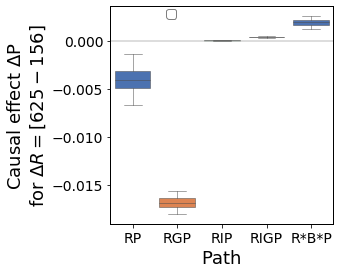

In [39]:
causal_effects, estimates2, estimates_sc = wrapper_for_causal_effec_estimation(df, N_sample=1000,
                                proxy_gustfront='massflux_u_mean_cpe', proxy_cptype ='intensity_sum_cp',
                                synoptic_variables = ['sc_deep_shear', 'sc_BRN'])
fig = plt.figure(figsize=[4,4])
ax0 = sns.boxplot(data = causal_effects, x ='path', y ='causal_effect_denorm', sym='', palette = secondary_colors[:4], linewidth=.5, 
                  whis=[2.5,97.5], saturation=1)
leg = ax0.legend(bbox_to_anchor=(.25, .99), loc=2, borderaxespad=0.,fontsize=13 )
leg.get_frame().set_alpha(0.5)
plt.hlines(0,-.5,4.5, color ='lightgrey')
plt.ylabel(r'Causal effect $\Delta$P'+'\n'+r'for $\Delta R= [625-156] $')
plt.xlabel('Path')

  0%|          | 0/1000 [00:00<?, ?it/s]/software/opt/bionic/x86_64/python/3.7-2019.07/lib/python3.7/site-packages/ipykernel_launcher.py:120: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

100%|██████████| 1000/1000 [02:40<00:00,  6.39it/s]


Text(0.5, 0, 'Path')

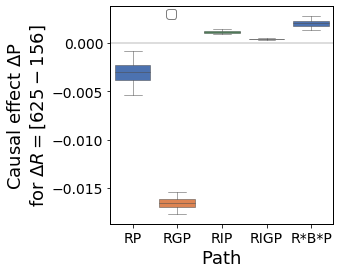

In [40]:
causal_effects, estimates2, estimates_sc = wrapper_for_causal_effec_estimation(df, N_sample=1000,
                                proxy_gustfront='massflux_u_mean_cpe', proxy_cptype ='intensity_sum_cp',
                                synoptic_variables = [  'sc_z_pbl','sc_wa_5km'])
fig = plt.figure(figsize=[4,4])
ax0 = sns.boxplot(data = causal_effects, x ='path', y ='causal_effect_denorm', sym='', palette = secondary_colors[:4], linewidth=.5, 
                  whis=[2.5,97.5], saturation=1)
leg = ax0.legend(bbox_to_anchor=(.25, .99), loc=2, borderaxespad=0.,fontsize=13 )
leg.get_frame().set_alpha(0.5)
plt.hlines(0,-.5,4.5, color ='lightgrey')
plt.ylabel(r'Causal effect $\Delta$P'+'\n'+r'for $\Delta R= [625-156] $')
plt.xlabel('Path')

  0%|          | 0/1000 [00:00<?, ?it/s]/software/opt/bionic/x86_64/python/3.7-2019.07/lib/python3.7/site-packages/ipykernel_launcher.py:120: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

100%|██████████| 1000/1000 [02:41<00:00,  6.49it/s]


Text(0.5, 0, 'Path')

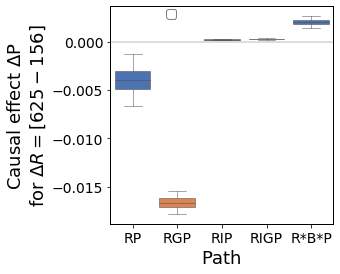

In [41]:
causal_effects, estimates2, estimates_sc = wrapper_for_causal_effec_estimation(df, N_sample=1000,
                                proxy_gustfront='massflux_u_mean_cpe', proxy_cptype ='intensity_sum_cp',
                                synoptic_variables = ['sc_cin_ml', 'sc_BRN'])
fig = plt.figure(figsize=[4,4])
ax0 = sns.boxplot(data = causal_effects, x ='path', y ='causal_effect_denorm', sym='', palette = secondary_colors[:4], linewidth=.5, 
                  whis=[2.5,97.5], saturation=1)
leg = ax0.legend(bbox_to_anchor=(.25, .99), loc=2, borderaxespad=0.,fontsize=13 )
leg.get_frame().set_alpha(0.5)
plt.hlines(0,-.5,4.5, color ='lightgrey')
plt.ylabel(r'Causal effect $\Delta$P'+'\n'+r'for $\Delta R= [625-156] $')
plt.xlabel('Path')